Authors:

*Álvaro Arroyo alvaro.arroyo@univ.ox.ac.uk*, *Haitz Sáez de Ocariz Borde haitz.saezdeocarizborde@eng.ox.ac.uk*, and *Federico Barbero federico.barbero@cs.ox.ac.uk*.


Based off of a notebook by Chaitanya K. Joshi, Charlie Harris, and Ramon Viñas Torné.

#Practical 3: Invariant and Equivariant GNNs 😀


## Introduction

Graph Neural Networks (GNNs) are a part of a broad and emerging research paradigm called **Geometric Deep Learning** -- devising neural network architectures that respect the invariances and symmetries in data. This practical aims to be a gentle introduction into the world of Geometric Deep Learning.

The **aims** of this practical are as follows:

* Understanding **invariant** and **equivariant** properties of Graph Neural Networks, from theory and proofs to programming and unit testing.
* Becoming hands-on with [**PyTorch Geometric**](https://pytorch-geometric.readthedocs.io/en/latest/) (PyG), a popular libary 
for developing state-of-the-art GNNs and Geometric Deep Learning models. In particular, gaining familiarity with the `MessagePassing` base class for designing novel GNN layers and the `Data` object for representing graph datasets.
* Gaining an appreciation of the fundamental principles behind constructing GNN layers that take advantage of **geometric information** for graph data located in **3D space**, a highly active area of GNN research.

# ⚙️ Part 0: Installation and Setup

**❗️Note:** You will need a GPU to complete this practical. Remember to click `Runtime -> Change runtime type`, and set the `hardware accelerator` to **GPU**.

In [1]:
#@title [RUN] Install required libraries
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install networkx

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install -q rdkit-pypi==2021.9.4
!pip install -q py3Dmol==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 923.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account 

In [2]:
#@title [RUN] Import python modules

import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 1.12.1+cu113
PyG version 2.3.0


In [3]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [4]:
#@title [RUN] Helper functions for data preparation

class SetTarget(object):
    """
    This transform mofifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target  
        data.y = data.y[:, target]
        return data


class CompleteGraph(object):
    """
    This transform adds all pairwise edges into the edge index per data sample, 
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [5]:
#@title [RUN] Helper functions for visualization

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

In [6]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

Great! We are ready to dive into Lab 3!

---
---
---

# 🧪 Part 0: Introduction to Molecular Property Prediction with PyTorch Geometric

This section covers the fundamentals. We will study how Graph Neural Networks (GNNs) can be employed for predicting chemical properties of molecules, an impactful real-world application of Geometric Deep Learning. To achieve this, we will first introduce PyTorch Geometric, a widely-used Python library that facilitates the implementation of GNNs.

## PyTorch Geometric

[PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) (PyG) is an excellent library for graph representation learning research and development:

> PyTorch Geometric (PyG) consists of various methods for deep learning on graphs and other irregular structures, also known as Geometric Deep Learning, from a variety of published papers. In addition, it provides easy-to-use mini-batch loaders for operating on many small and single giant graphs, multi GPU-support, distributed graph learning, a large number of common benchmark datasets, and helpful transforms, both for learning on arbitrary graphs as well as on 3D meshes or point clouds.

In this practical, we will make extensive use of PyG. If you have never worked with PyG before, do not worry, we will provide you with some examples and guide you through all the fundamentals in a detailed manner. We also highly recommend [this self-contained official tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html), which will help you get started. Among other things, you will learn how to implement state-of-the-art GNN layers via the generic PyG [Message Passing](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) class (more on this later).

Now, let's turn our attention to the problem of predicting molecular properties.

## Molecular Property Prediction

Molecules are a great example of an object from nature that can easily be represented as a graph of atoms (nodes) connected by bonds (edges). 
A popular application of GNNs in chemistry is the task of **Molecular Property Prediction**. The goal is to train a GNN model from historical experimental data that can predict useful properties of drug-like molecules. The model's predictions can then be used to guide the drug design process.

<!-- ![](https://drive.google.com/uc?id=1Hs6fMSZ6a0WdjKqzbmBME0RYoSwxMaYQ) -->
<img src="https://github.com/chaitjo/dump/raw/main/molproppred.png">

One famous example of GNNs being used in molecular property prediction is in the world of **antibiotic discovery**, an area with a potentially massive impact on humanity and infamously little innovation. A GNN trained to predict how much a molecule would inhibit a bacteria was able identify the previously overlooked compound [**Halicin**](https://www.wikiwand.com/en/Halicin) (below) during virtual screening. Not only did halicin show powerful results during *in vitro* (in cell) testing but it also had a completely novel mechanism of action that no bacteria has developed resistance to (yet).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Halicin.svg/440px-Halicin.svg.png" width="30%">

## The QM9 Dataset

QM9 (Quantum Mechanics dataset 9) is a dataset consisting of about **130,000 small molecules** with 19 regression targets. Since being used by [MoleculeNet](https://arxiv.org/abs/1703.00564), it has become a popular dataset to benchmark new architectures for molecular property prediction.

Specifically, we will be predicting the [electric dipole moment](https://en.wikipedia.org/wiki/Electric_dipole_moment) of drug-like molecules. According to Wikipedia:
> "The electric dipole moment is a measure of the separation of positive and negative electrical charges within a system, that is, a measure of the system's overall polarity."

We can visualize this concept via the water molecule H<sub>2</sub>0, which forms a dipole due to its slightly different distribution of negative (blue) and postive (red) charge.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Water-elpot-transparent-3D-balls.png/500px-Water-elpot-transparent-3D-balls.png" width="25%">

You do not need to worry about the exact physical and chemical principles that underpin dipole moments. As you might imagine, writing the equations from first priciples to predict a property like this, espeically for complex molecules (e.g. proteins), is very difficult. All you need know (for the sake of this practical anyway) is that these molecules can be representated as graphs with node and edge features as well as **spatial information** that we can use to train a GNN model using the ground truth labels.

Now let us load the QM9 dataset and explore how molecular graphs are represented. PyG makes this extremely convenient.

(The dataset may take a few minutes to download.)

In [7]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    transform = T.Compose([CompleteGraph(), SetTarget()])
    
    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

Extracting qm9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:14<00:00, 689.51it/s]
Done!
/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## Data Preparation and Splitting

The QM9 dataset has over **130,000** molecular graphs! 

Let us create a more tractable sub-set of **3,000** molecular graphs for the purposes of this practical and separate it into training, validation, and test sets. We shall use 1,000 graphs each for training, validation, and testing.

Towards the end of this practical, you will get to experiment with the full/larger sub-sets of the QM9 dataset, too.

In [8]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


## Visualising Molecular Graphs

To get a better understanding of how the QM9 molecular graphs look like, let's visualise a few samples from the training set along with their corresponding target (their dipole moment).

In the following plot we visualise **sparse graphs** where edges represent physical connections (i.e. bonds). In this practical, however, we will use **fully-connected graphs** and encode the graph structure in the attributes of each. Later in this practical, we will study the advantages and downsides of both approaches.

**❗️Note:** we have implemented some code for you to convert the PyG graph into a Molecule object that can be used by RDKit, a python package for chemistry and visualing molecules. It is not important for you to understand RDKit beyond visualisation purposes.

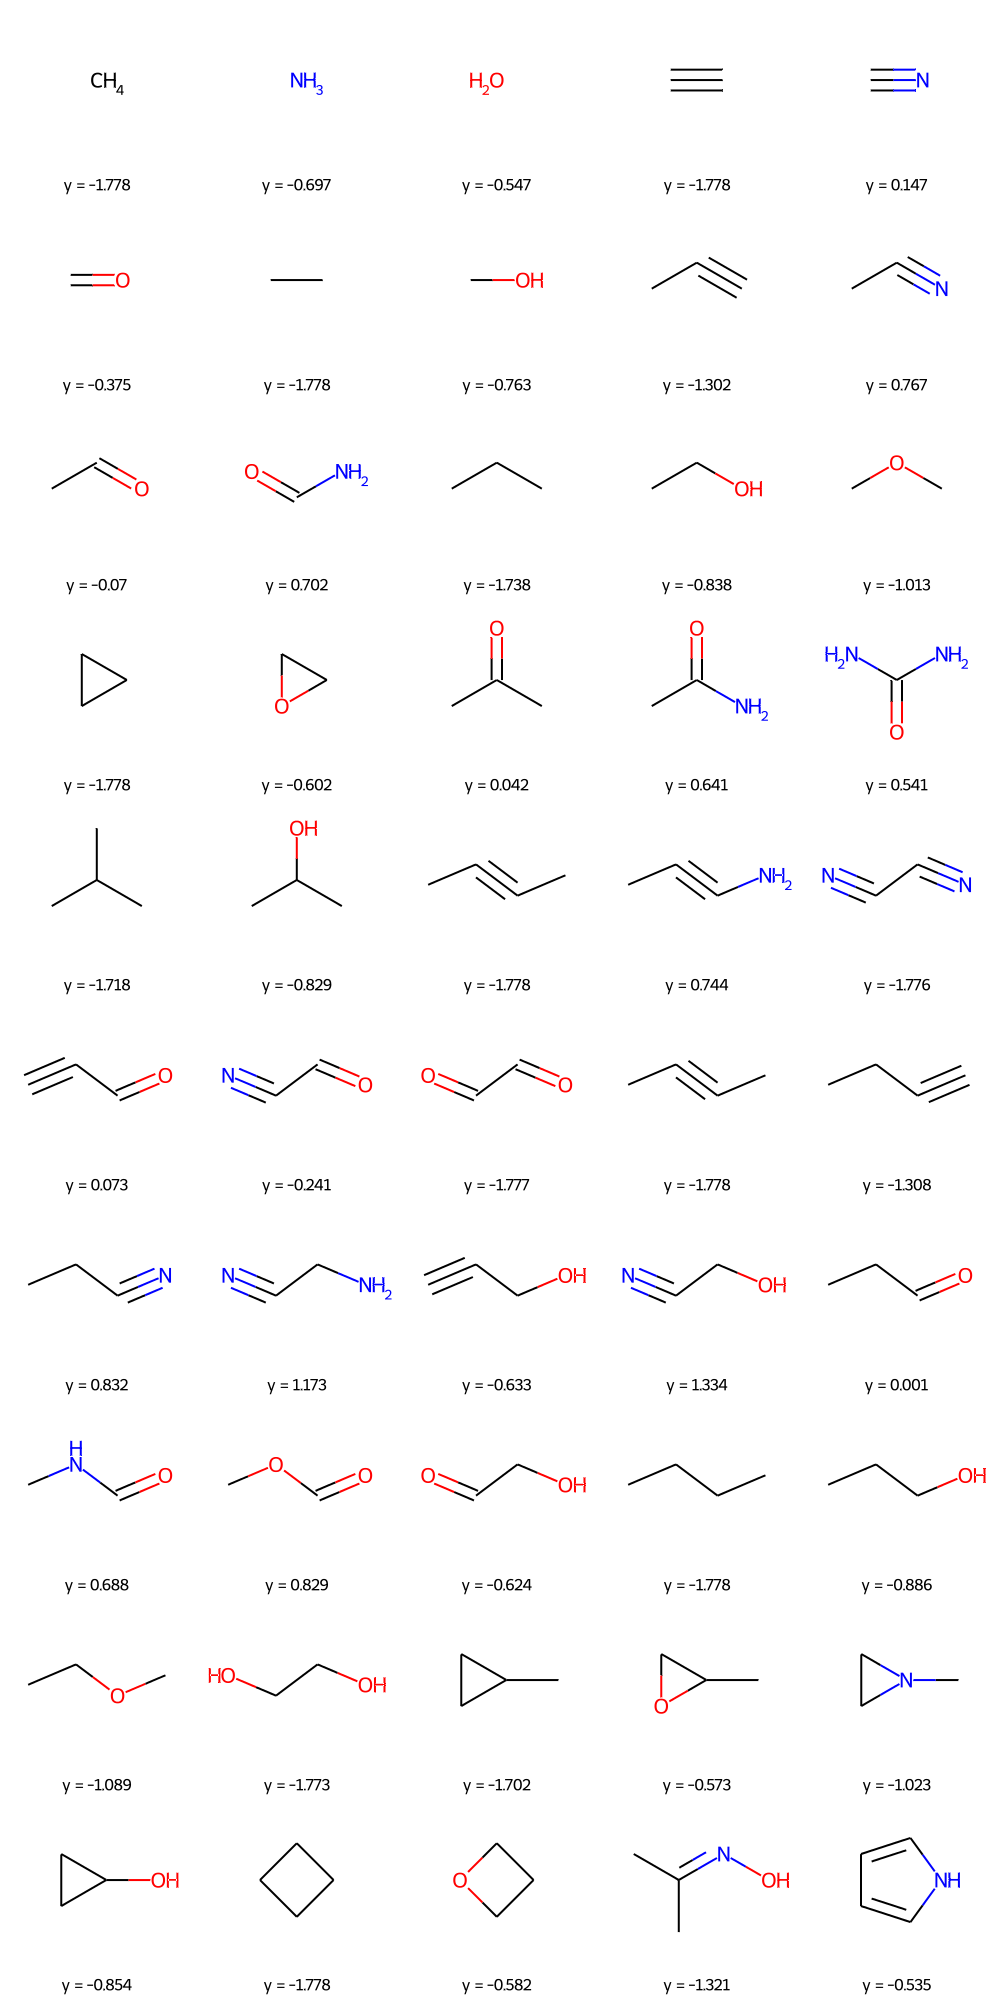

In [9]:
num_viz = 50
mols = [to_rdkit(train_dataset[i]) for i in range(num_viz)]
values = [str(round(float(train_dataset[i].y), 3)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

## Understanding PyG Data Objects

Each graph in our dataset is encapsulated in a PyG `Data` object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [10]:
data = train_dataset[0] # one data sample, i.e. molecular graph
print("Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:")
print(data)

Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 4], y=[1], pos=[5, 3], z=[5], name='gdb_1', idx=[1])


Within an instance of a `Data` object, individual `Torch.Tensor` attributes (or any other variable type) can be easily dot accessed within a neural network layer. The graphs from PyG come with a number of pre-computed features which we describe below (do not worry if you are unfamiliar with the chemistry terms here):

**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F)
- 6th feature (also `data.z`): Atomic number (number of protons).
- 7th feature: Aromatic (binary)
- 8th-10th features: Electron orbital hybridization (one-hot: sp, sp2, sp3)
- 11th feature: Number of hydrogens

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describe the edge connectivity of the graph

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: bond type (one-hot: single, double, triple, aromatic)

**Atom positions (`data.pos`)** - $\mathbb{R}^{|V|\times 3}$
- 3D coordinates of each atom . (We will talk about their importance later in the practical.)

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the molecules electric dipole moment

**❗️Note:** We will be using **fully-connected graphs** (i.e. all atoms in a molecule are connected to each other, except self-loops). The information about the molecule structures will be available to the models through the edge features (`data.edge_attr`) as follows:
- When two atoms are physically connected, the edge attributes indicate the **bond type** (single, double, triple, or aromatic) through a one-hot vector.
- When two atoms are not physically connected, **all edge attributes** are **zero**.
We will later study the advantages/downsides of fully-connected adjacency matrices versus sparse adjacency matrices (where an edge between two atoms is present only when there exists a physical connection between them).

In [11]:
print(f"\nThis molecule has {data.x.shape[0]} atoms, and {data.edge_attr.shape[0]} edges.")

print(f"\nFor each atom, we are given a feature vector with {data.x.shape[1]} entries (described above).")

print(f"\nFor each edge, we are given a feature vector with {data.edge_attr.shape[1]} entries (also described above).")

print(f"\nIn the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.")

print(f"\nEach atom also has a {data.pos.shape[1]}-dimensional coordinate associated with it. We will talk about their importance later in the practical.")

print(f"\nFinally, we have {data.y.shape[0]} regression target for the entire molecule.")


This molecule has 5 atoms, and 20 edges.

For each atom, we are given a feature vector with 11 entries (described above).

For each edge, we are given a feature vector with 4 entries (also described above).

In the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.

Each atom also has a 3-dimensional coordinate associated with it. We will talk about their importance later in the practical.

Finally, we have 1 regression target for the entire molecule.


## Using PyG for batching

As you might remember from the previous practical, **batching graphs** can be quite a tedious and fiddly process. Thankfully, using PyG makes this super simple! Given a list of `Data` objects, we can easily batch this into a PyG `Batch` object as well as unbatch back into a list of graphs. Furthermore, in simple cases like ours, the PyG `DataLoader` object (different from the vanilla PyTorch one) handles all of the batching under the hood for us!

Lets quicky batch and unbatch some graphs anyway as a demonstration:

In [12]:
# Toy graph 1
edge_index_1 = torch.tensor(
    [[0, 1, 1, 2], [1, 0, 2, 1]], 
    dtype=torch.long
)
x_1 = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data_1 = Data(x=x_1, edge_index=edge_index_1)

# Toy graph 2
edge_index_2 = torch.tensor(
    [[0, 2, 1, 0], [2, 0, 0, 1]], 
    dtype=torch.long
)
x_2 = torch.tensor([[1], [0], [-1]], dtype=torch.float)

data_2 = Data(x=x_2, edge_index=edge_index_2)

# Create batch from toy graphs
data_list = [data_1, data_2]
batch = Batch.from_data_list(data_list)

assert (batch[0].x == data_1.x).all() and (batch[1].x == data_2.x).all()

# Create DataLoader
loader = DataLoader(data_list, batch_size=1, shuffle=False)
it = iter(loader)
batch_1 = next(it)
batch_2 = next(it)

assert (batch_1.x == data_1.x).all() and (batch_2.x == data_2.x).all()

Awesome! We have downloaded and prepared the QM9 dataset, visualised some samples, understood the attributes associated with each molecular graph, and reviewed how batching works in PyG. Now, we are ready to understand how we can develop GNNs in PyG for molecular property prediction.

---
---
---

# 📩 Part 0: Introduction to Message Passing Neural Networks in PyTorch Geometric

As a gentle introduction to PyTorch Geometric, we will walk you through the first steps of developing a GNN in the **Message Passing** flavor.

<!-- ![](https://drive.google.com/uc?id=1Wdgdq606XW1MelvcU1nW5CxWe1rHsWt1) -->
<img src="https://github.com/chaitjo/dump/raw/main/gnn-layers.png">

## Formalism

Firstly, let us formalise our molecular property prediction pipeline. (Our notation will mostly follow what has been introduced in the lectures, but we do make some different choices for variable names.)

### Graph 
Consider a molecular graph $\mathcal{G} = \left( \mathcal{V}, \mathcal{E} \right)$, where $\mathcal{V}$ is a set of $n$ nodes, and $\mathcal{E}$ is a set of edges associated with the nodes. For each node $i \in \mathcal{V}$, we are given a $d_n$-dimensional initial feature vector $h_i \in \mathbb{R}^{d_n}$.
For each edge $(i, j) \in \mathcal{E}$, we are given a $d_e$-dimensional initial feature vector $e_{ij} \in \mathbb{R}^{d_e}$. For QM9 graphs, $d_n = 11, d_e = 4$.

### Label/target 
Associated with each graph $\mathcal{G}$ is a scalar target or label $y \in \mathbb{R}^{1}$, which we would like to predict. 

We will design a Message Passing Neural Network for graph property prediction to do this. Our MPNN will consist of several layers of message passing, followed by a global pooling and prediction head.

### MPNN Layer 
The Message Passing operation iteratively updates node features $h_i^{\ell} \in \mathbb{R}^d$ from layer $\ell$ to layer $\ell+1$ via the following equation:
$$
h_i^{\ell+1} = \phi \Bigg( h_i^{\ell}, \oplus_{j \in \mathcal{N}_i} \Big( \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right) \Big) \Bigg),
$$
where $\psi, \phi$ are Multi-Layer Perceptrons (MLPs), and $\oplus$ is a permutation-invariant local neighborhood aggregation function such as summation, maximization, or averaging.

Let us break down the MPNN layer into three pedagogical steps:
- **Step (1): Message.** For each pair of linked nodes $i, j$, the network first computes a message $m_{ij} =  \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right)$. The MLP $\psi: \mathbb{R}^{2d + d_e} → \mathbb{R}^d$ takes as input the concatenation of the feature vectors from the source node, destination node, and edge.
    - Note that for the first layer $\ell=0$, $h_i^{\ell=0} = W_{in} \left( h_i \right)$, where $W_{in} \in \mathbb{R}^{d_n}  \rightarrow \mathbb{R}^{d}$ is a simple linear projection (`torch.nn.Linear`) for the initial node features to hidden dimension $d$.
- **Step (2): Aggregate.** At each node $i$, the incoming messages from all its neighbors are then aggregated as $m_{i} = \oplus_{{j \in \mathcal{N}_i}} \left( m_{ij} \right)$, where $\oplus$ is a permutation-invariant function. We will use summation, i.e. $\oplus_{{j \in \mathcal{N}_i}} = \sum_{{j \in \mathcal{N}_i}}$.
- **Step (3): Update.** Finally, the network updates the node feature vector $h_i^{\ell+1} = \phi \left( h_i^{\ell}, m_i \right)$, by concatenating the aggregated message $m_i$ and the previous node feature vector $h_i^{\ell}$, and passing them through an MLP $\phi: \mathbb{R}^{2d} → \mathbb{R}^{d}$.

### Global Pooling and Prediction Head
After $L$ layers of message passing, we obtain the final node features $h_i^{\ell=L}$. As we have a single target $y$ per graph, we must pool all node features into a single graph feature or graph embedding $h_G \in \mathbb{R}^d$ via another permutation-invariant function $R$, sometimes called the 'readout' function, as follows:
$$
h_G = R_{i \in \mathcal{V}} \left( h_i^{\ell=L} \right). 
$$ 
We will use global average pooling over all node features, i.e.
$$
h_G = \frac{1}{|\mathcal{V}|} \sum_{i \in \mathcal{V}} h_i^{\ell=L}. 
$$

The graph embedding $h_G$ is passed through a linear prediction head $W_{pred} \in \mathbb{R}^{d} \rightarrow \mathbb{R}^1$ to obtain the overall prediction $\hat y \in \mathbb{R}^1$:
$$
\hat y = W_{pred} \left( h_G \right).
$$ 

### Loss Function
Our MPNN graph property prediction model can be trained end-to-end via minimizing the standard mean-squared error loss for regression:
$$
\mathcal{L}_{MSE} = \lVert y - \hat y \rVert^2_2.
$$

## Coding the basic Message Passing Neural Network Layer

We are now ready to define a basic MPNN layer which implements what we have described above. In particular, we will code up the **MPNN Layer** first. (We will code up the other parts subsequently.)

To do so, we will inherit from the `MessagePassing` base class, which automatically takes care of message propagation and is extremely useful to develop advanced GNN models. To implement a custom MPNN, the user only needs to define the behaviour of the `message` (i.e. $\psi$), the `aggregate`(i.e. $\oplus$), and `update` (i.e. $\phi$) functions. You may also refer to the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) for implementing custom message passing layers.

Below, we provide the implementation of a standard MPNN layer as an example, with extensive inline comments to help you figure out what is going on.

In [13]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the 
        message passing procedure: `message()` -> `aggregate()` -> `update()`.
        
        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`, 
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j 
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take 
        any arguments that were initially passed to `propagate`. Additionally, 
        we can differentiate destination nodes and source nodes by appending 
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`. 
        
        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`, 
        as well as any optional arguments that were initially passed to 
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

Great! We have defined a **Message Passing layer** following the equation we had introduced previously. Let us use this layer to code up the full **MPNN graph property prediction model**. This model will take as input molecular graphs, process them via multiple MPNN layers, and predict a single property for each of them.

In [14]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Awesome! We are done defining our first MPNN model for graph property prediction.

But wait! Before we dive into training and evaluation this model, let us write some sanity checks for a **fundamental property** of the model and the layer.

## Unit tests for Permutation Invariance and Equivariance

The lectures have repeatedly indicated on certain fundamental properties for machine learning on graphs:
- A **GNN <ins>layer**</ins> is **equivariant** to permutations of the set of nodes in the graph; i.e. as we permute the nodes, the node features produced by the GNN must permute accordingly.
- A **GNN <ins>model**</ins> for graph-level property prediction is **invariant** to the permutations of the set of nodes in the graph; i.e. as we permute the nodes, the graph-level property remains unchanged.

(But wait...**What is a permutation?** Essentially, it is an **ordering of the nodes** in a graph. In general, there is **no canonical way** of assigning an ordering of the nodes, unlike textual or image data. However, graphs need to be stored and processed on computers in order to perform machine learning on them (which is what this course is about!). Thus, we need to ensure that our models are able to principaly handle this **lack of canonical ordering** or permutation of graph nodes. This is what the above statements are trying to say.)

### Formalism

Let us try to formalise these notions of permutation invariance and equivariance via matrix notation (it is easier that way).

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features and adjacency matrix, and returns the **predicted graph-level property**.
- Let $\mathbf{P} \in \mathbb{R}^{n \times n}$ be a **[permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix)** which has exactly one 1 in every row and column, and 0s elsewhere. Left-multipying $\mathbf{P}$ with a matrix changes the ordering of the rows of the matrix.

### Permuation Equivariance

The GNN <ins>layer</ins> $\mathbf{F}$ is **permuation equivariant** as follows:
$$ 
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{F}(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the updated node features $\mathbf{H'} = \mathbf{F}(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN layer $\mathbf{F}$ should produce the same result as applying the same permutation on $\mathbf{H'}$:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{H'}
$$

### Permuation Invariance

The GNN <ins>model</ins> $f$ for graph-level prediction is **permutation invariant** as follows:
$$ 
f(\mathbf{PH}, \mathbf{PAP^T}) = f(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the predicted molecular property $\mathbf{\hat y} = f(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN model $f$ should produce the same result as not applying it:
$$ 
f(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{\hat y}.
$$

With that formalism out of the way, let us write some unit tests to confirm that our `MPNNModel` and `MPNNLayer` are indeed permutation invariant and equivariant, respectively.

In [15]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.pos = data.pos[perm]
    data.z = data.z[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note: 
    # (1) While we originally defined the permutation matrix P as only having 
    #     entries 0 and 1, its implementation via `perm` uses indexing into 
    #     torch tensors, instead. 
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant 
    #     dummy values. For any experiments beyond unit testing, all GNN models 
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is 
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is 
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

Now that we have defined the unit tests for permutation invariance (for the full MPNN model) and permutation equivariance (for the MPNN layer), let us perform the sanity check:

In [16]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


## Training and Evaluating Models

Great! We are finally ready to train and evaluate our model on QM9. We have provided a **basic experiment loop** which takes as input the model and dataloaders, performs training, and returns the final performance on the **validation** and **test set**.

We will be training a `MPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64.

In [17]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [18]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=11, out_features=64, bias=True)
  (convs): ModuleList(
    (0): MPNNLayer(emb_dim=64, aggr=add)
    (1): MPNNLayer(emb_dim=64, aggr=add)
    (2): MPNNLayer(emb_dim=64, aggr=add)
    (3): MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103233

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.5002329, Val MAE: 1.3839374, Test MAE: 0.9410032
Epoch: 020, LR: 0.001000, Loss: 0.4325893, Val MAE: 0.9589760, Test MAE: 0.7390912
Epoch: 030, LR: 0.000900, Loss: 0.3612851, Val MAE: 0.9192157, Test MAE: 0.6999987
Epoch: 040, LR: 0.000900, Loss: 0.2940805, Val MAE: 3.2967770, Test MAE: 0.6923739
Epoch: 050, LR: 0.000810, Loss: 0.2342371, Val MAE: 0.8155372, Test MAE: 0.6248005
Epoch: 060, LR: 0.000810, Loss: 0.2063263, Val MAE: 0.8143036, Test MAE: 0.6438460
Epoch: 070, LR: 0.000729, Loss: 0

In [19]:
RESULTS

{'MPNNModel': (0.7151353430747985, 0.5963034381866456, 2.32489990790685)}

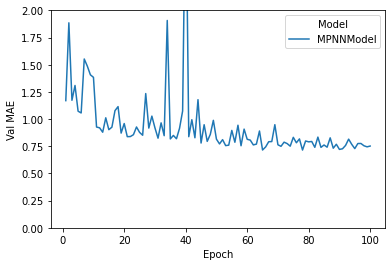

In [20]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

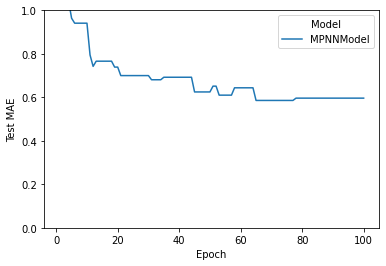

In [21]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Super! Everything up to this point has already been covered in the lectures, and we hope that the practical so far has been a useful recap along with the acompanying code.

Now for the fun part, where you will be required to think what you have studied so far!

---
---
---

# 🧊 Part 1: Geometric Graphs and Message Passing with 3D Coordinates

Remember that we were given **3D coordinates** with each atom in our molecular graph?

Molecular graphs, and other structured data occurring in nature, do not simply exist on flat planes. Instead, molecules have an **inherent 3D structure** that influences their properties and functions.

Let us visualize a molecule from QM9 in all of its 3D glory! 

Go ahead and try move this molecule with your mouse cursor!

In [22]:
MolTo3DView(smi2conf(Chem.MolToSmiles(to_rdkit(train_dataset[48]))))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 💻**Task 1.1:** Develop a Message Passing Neural Network that incorporates the atom coordinates as node features.


Our initial and somewhat **'vanilla' MPNN** `MPNNModel` ignores the atom coordiantes and only uses the node features to perform message passing. This means that the model is **not** leveraging useful **3D structural information** to predict the target property.

Your first task is to modify the original `MPNNModel` to incorporate **atom coordinates** into the **node features**.

We have defined most of the new `CoordMPNNModel` class for you, and you have to fill in the `YOUR CODE HERE` sections.

🤔 *Hint: As reminder, the 3D atom positions are stored in `data.pos`. You don't have to do something very smart right now (that will come later). A **simple** solution is okay to get started, e.g. concatenation of the coordinates and features*


In [23]:
class CoordMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # ============ YOUR CODE HERE ==============
        # Adapt the input linear layer or add new input layers 
        # to account for the atom positions.
        #
        # Linear projection for initial node features and coordinates
        # dim: d_n + 3 -> d
        self.lin_in = Sequential(
            Linear(in_dim + 3, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        # ==========================================
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        # ============ YOUR CODE HERE ==============
        # Incorporate the atom positions along with the features.
        #
        h = self.lin_in(torch.cat((data.x,data.pos), dim = 1)) # (n, d_n) -> (n, d)
        
        # ==========================================
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

## 💻**(Bonus) Task 1.2** Test the permutation invariance and equivariance properties of your new `CoordMPNNModel` with node features and coordinates, as well as the constituent `MPNNLayer`.

Super! You have successfully implemented an MPNN which utilises both the **atom features** as well as **coordinates** to predict molecular properties. 

Before we evaluate it, let us once again run the permutation sanity checks again to make sure the model and layer have the desired properties that constitute every basic GNN:
- The `MPNNLayer` should be permutation equivariant (we have already shown this previously, but we want you to repeat the exercise in order to **thoroughly** understand it).
- The `CoordMPNNModel` should be permutation invariant.

Your task is to fill in the `YOUR CODE HERE` sections to run the required unit tests. You do not need to write new unit tests yet, the ones we defined previously can be re-used.

In [24]:
# ============ YOUR CODE HERE ==============
# Instantiate temporary model, layer, and dataloader for unit testing.
# Remember that we are now unit testing the CoordMPNNModel, which is different
# than the previous model but still composed of the MPNNLayer.
#
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is CoordMPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


## 💻**(Bonus) Task 1.3.** Is the `CoordMPNNModel` invariant to permutations of both the nodes?

🤔 *Hint: We are looking for simple statements here. You can additionally introduce $\mathbf{X} \in \mathbb{R}^{n \times 3}$ as the matrix of node coordinates for a given molecular graph. Use $\mathbf{H}$ as the feature matrix, following the notation from above.*


---

<font color='red'>❗️YOUR ANSWER HERE</font>
Yes
$$ 
f(\mathbf{PH}, \mathbf{PX}, \mathbf{PAP^T}) = 
f(\mathbf{P(H,X)}, \mathbf{PAP^T}) = 
f(\mathbf{(H,X)}, \mathbf{PAP^T})
f(\mathbf{H},\mathbf{X}, \mathbf{A}).
$$
---

## 💻**Task 1.4.** Train and evaluate your `CoordMPNNModel` with node features and coordinates on QM9.

Awesome! You are now ready to train and evaluate our new MPNN with node features and coordinates on QM9.

Re-use the experiment loop we have provided and fill in the `YOUR CODE HERE` sections to run the experiment.

You will be training a `CoordMPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64, in order to compare your result fairly to the previous vanilla `MPNNModel`.

In [25]:
# ============ YOUR CODE HERE ==============
# Instantiate your CoordMPNNModel with the appropriate arguments.
#
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, # "MPNN w/ Features and Coordinates", 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for CoordMPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
CoordMPNNModel(
  (lin_in): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (convs): ModuleList(
    (0): MPNNLayer(emb_dim=64, aggr=add)
    (1): MPNNLayer(emb_dim=64, aggr=add)
    (2): MPNNLayer(emb_dim=64, aggr=add)
    (3): MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 107841

Start training:
Epoch: 010, LR: 0.000900, Loss: 0.2872755, Val MAE: 1.0409621, Test MAE: 0.8696517
Epoch: 020, LR: 0.000810, Loss: 0.1930102, Val MAE: 0.8984580, Test MAE: 0.7529717
Epoch: 030, LR: 0.000810, Loss: 0.1483085, Val MAE: 1.008585

In [26]:
RESULTS

{'MPNNModel': (0.7151353430747985, 0.5963034381866456, 2.32489990790685),
 'CoordMPNNModel': (0.8119742546081543,
  0.6663969583511352,
  2.2694135030110676)}

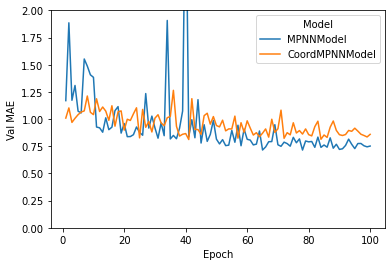

In [27]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

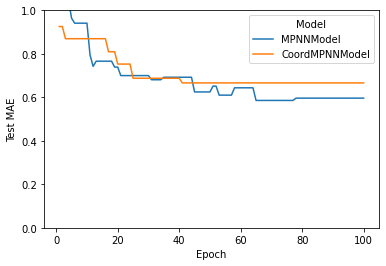

In [28]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Hmm... If you've implemented the `CoordMPNNModel` correctly up till now, you may see a very curious result -- the performance of `CoordMPNNModel` is about equal or marginally worse than the vanilla `MPNNModel`!

<font color='red'>This is because the `CoordMPNNModel` is not using 3D structural information in a principled manner.</font>

The next sections will help us formalise and understand why this is happening.

---
---
---

# 🔄 Part 2: Invariance to 3D Symmetries: Rotation and Translation

We saw that the performance of `CoordMPNNModel` is unexpectedly mediocre compared to `MPNNModel` despite using both node features and coordinates. (But please do not panic if your results say otherwise.) In order to determine why, we must understand the concept of **3D symmetries**.

### Geometric Invariance

Recall that molecular graphs have 3D coordinates for each atom. A key detail which we have purposely withheld from you up till this point (😈) is that these 3D coordinates are **not  inherently fixed** or **permanent**. Instead, they were **experimentally determined** relative to a **frame of reference**.

To fully grasp these statements, here is GIF of a drug-like molecules moving around in 3D space...

<!-- ![](https://drive.google.com/uc?id=1QcQcF91TD-CTKFaR4NN8YyXbtSTcGny8) -->
<img src="https://github.com/chaitjo/dump/raw/main/3d-molecule-moving.gif">

The atoms' 3D coordinates are constantly **rotating** and **translating**. However, the **properties** of this molecule will always remain the same no matter how we rotate or translate it. In other words, the molecule's properties are **invariant** to 3D rotations and translations.

In this block we will study how to design GNN layers and models that respect these regularities.

### Formalism

Let us try to formalise the notion of invariance to 3D rotations and translations in GNNs via matrix notation.

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{X} \in \mathbb{R}^{n \times 3}$ be a matrix of node coordinates for a given molecular graph, where $n$ is the number of nodes/atoms and each row $x_i$ is the 3D coordinate for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **predicted graph-level property**.

(Notice that we have updated the notation for the GNN layer $\mathbf{F}$ and GNN model $\mathbf{f}$ to include the matrix of node coordinates $\mathbf{X}$ as an additional input.) 

## 💻**(Bonus) Task 2.1:** What does it mean for the GNN <ins>model</ins> $f$ and the GNN <ins>layer</ins> $\mathbf{F}$ to be invariant to 3D rotations and translations? Express this _mathematically_ using the definitions above.

🤔 *Hint: Revisit the formalisms for permutation invariance and equivariance to get an idea of how to go about this. You should use the matrix notation we have provided above. Similar to the permuatation matrix $\mathbf{P}$, you may now define an orthogonal [**rotation matrix**](https://en.wikipedia.org/wiki/Rotation_matrix) $\mathbf{Q} \in \mathbb{R}^{3 \times 3}$ and a [**translation vector**](https://en.wikipedia.org/wiki/Translation_(geometry)) $\mathbf{t} \in \mathbb{R}^3$ in your answer. These would operate on the matrix of node coordinates $\mathbf{X} \in \mathbb{R}^3$*.

---

<font color='red'>❗️YOUR ANSWER HERE</font>
$$ 
\mathbf{F}(\mathbf{H}, \mathbf{QX+t},\mathbf{A}) =  \ \mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}).
$$


---

Before you start coding up a more principled MPNN model, we would like you to take a moment to think about why invariance to 3D rotations and translations is something desirable for GNNs predicting molecular properties. Is training a model with data augmentation to "learn" this type of invariance a better solution than encoding this inductive bias directly into the model's architecture?

## 💻**Task 2.2:** Is invariance to 3D rotations and translations a desirable property for GNNs? Explain why. 

🤔 *Hint: No need for a magnum opus, a few sentences suffice.*

---

<font color='red'>❗️YOUR ANSWER HERE</font>

We need it now.
But if we need the information of 3D rotation, we do not need the invariance layer.
---

## 💻**Task 2.3:** Write the unit test to check your `CoordMPNNModel` for 3D rotation and translation invariance. 


🤔 *Hint: Show that the output of the model varies when:*
1. All the atom coordinates in `data.pos` are multiplied by any random _orthogonal_ rotation matrix $Q \in \mathbb{R}^{3 \times 3}$. (We have provided a helper function for creating rotation matrices.)
2. All the atom coordinates in `data.pos` are displaced by any random translation vector $\mathbf{t} \in \mathbb{R}^3$.

In [29]:
def random_orthogonal_matrix(dim=3):
  """Helper function to build a random orthogonal matrix of shape (dim, dim)
  """
  Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
  return Q


def rot_trans_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model/layer) is 
    rotation and translation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Forward pass on original example
    # Note: We have written a conditional forward pass so that the same unit
    #       test can be used for both the GNN model as well as the layer.
    #       The functionality for layers will be useful subsequently. 
    if isinstance(module, MPNNModel):
        out_1 = module(data)
    else: # if ininstance(module, MessagePassing):
        out_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    Q = random_orthogonal_matrix(dim=3)
    t = torch.rand(3)
    # ============ YOUR CODE HERE ==============
    # Perform random rotation + translation on data.
    #
    data.pos = data.pos @ Q + t
    # ==========================================

    # Forward pass on rotated + translated example
    if isinstance(module, MPNNModel):
        out_2 = module(data)
    else: # if ininstance(module, MessagePassing):
        out_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)
    
    # ============ YOUR CODE HERE ==============
    # Check whether output varies after applying transformations.
    # Hint: Since we are comparing floating points, we need to check
    # if the two numbers are within some small epsilon of each other
    # There may be a pytorch function that does this already over tensors ;)
    #
    return torch.allclose(out_1, out_2)
    # ==========================================

Now that you have defined the unit tests for rotation and translation invariance, perform the sanity check on your `CoordMPNNModel`:

(Spoiler alert: if you have implemented things as expected, the unit test should return `False` for the `CoordMPNNModel`.)

In [30]:
# Instantiate temporary model, layer, and dataloader for unit testing
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

Is CoordMPNNModel rotation and translation invariant? --> False!


In this part, you have formalised how a GNN can be 3D rotation and translation invariant, thought about why this is desirable for molecular property prediction, and shown that the `CoordMPNNModel` was not rotation and translation invariant.

At this point, you should have a concrete understanding of why the performance of `CoordMPNNModel` is equal or worse than the vanilla `MPNNModel`, and what we meant by our initial statement before we began this part: 
>"The `CoordMPNNModel` is not using 3D structural information in a principled manner" 

Let us try fixing this in the next part!

---
---
---

# ✈️ Part 3: Message Passing with Invariance to 3D Rotations and Translations

This section will dive into how we may design GNN models which operate on graphs with 3D coordinates in a more theoretically sound way.

## 💻**Task 3.1:** Design a new Message Passing Layer as well as the accompanying MPNN Model that are both <ins>invariant</ins> to 3D rotations and translations ($E(3)$).

**❗️ Note:** There is no single correct answer to this question.

Our initial **'vanilla' MPNN** `MPNNModel` and `MPNNLayer` ignored the atom coordiantes and only uses the node features to perform message passing. This means that the model was **not** leveraging **3D structural information** to predict the target property.

Our second **'naive' coordinate MPNN** `CoordMPNNModel` used the node features along with the atom coordinates in an unprincipled manner, resulting in the model not being invariant to 3D rotations and translations of the coordinates (which was a desirable property, as we saw in the previous part).

Your task is to define a new `InvariantMPNNLayer` which utilise both **atom coordinates** and **node features**.

We have defined most of the new `InvariantMPNNLayer`, and you have to fill in the `YOUR CODE HERE` sections. We have also already defined the `InvariantMPNNModel` that instantiates your new layer to compose the model. You only need to define the new layer.

🤔 *Hint 1: Unlike the previous `CoordMPNNModel`, we would suggest using the coodinate information to constuct the messages as opposed to incorporating it into the node features. In particular, we would like you to think about **how** to use the coordinates in a principled manner to constuct the messages: What is a measurement that we can computer using a pair of coordinates that will be invariant to rotating and translating them?*

🤔 *Hint 2:  tensors passed to `propagate()` can be mapped to the respective nodes  and  by appending `_i` or `_j` to the variable name, e.g. `h_i` and `h_j` for the node features `h`. Note that we generally refer to `_i` as the central nodes that aggregates information, and refer to `_j` as the neighboring nodes.*

In [31]:
class InvariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is invariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # MLP `\psi` for computing messages `m_ij`
        # dims: (???) -> d
        #
        self.mlp_msg = self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        # ==========================================
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> 
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        

    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument 
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        #?

        out = self.propagate(edge_index, pos = pos, h=h, edge_attr=edge_attr)
        return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write a custom `message()` function that takes as arguments the
    # source and destination node features, node coordiantes, and `edge_attr`.
    # Incorporate the coordinates `pos` into the message computation such
    # that the messages are invariant to rotations and translations.
    # This will ensure that the overall layer is also invariant.
    #
    def message(self, h_i, h_j, pos_i, pos_j, edge_attr):
      """The `message()` function constructs messages from source nodes j 
          to destination nodes i for each edge (i, j) in `edge_index`.
      
        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            pos_i: (e, 3) - destination node positions
            pos_j: (e, 3) - source node positions
            edge_attr: (e, d_e) - edge features
          
        Returns:
          msg: (e, d) - messages `m_ij` passed through MLP `\psi`
      """
      msg = torch.cat([h_i, h_j, torch.norm(pos_j - pos_i, dim = 1).unsqueeze(dim = 1), edge_attr], dim=-1)
      
      return self.mlp_msg(msg)
    # ==========================================
    
    def aggregate(self, inputs, index):
        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class InvariantMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of invariant MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(InvariantMPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.pos, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Super! You have now defined a more geometrically principled message passing layer and used it to construct an MPNN model with is invariant to 3D rotations and translations.

## 💻**Task 3.2:** Write down the update equation of your new `InvariantMPNNLayer` and use that to prove that the layer and model are invariant to 3D rotations and translations. 


---

<font color='red'>❗️YOUR ANSWER HERE</font>
$$ 
f(\mathbf{H}, \mathbf{norm2(QX+t)}, \mathbf{A}) = 
f(\mathbf{H}, \mathbf{norm2(QX)}, \mathbf{A}) = 
f(\mathbf{H},\mathbf{norm2(X)}, \mathbf{A}).
$$

---

Great! You have successfully written the update equation for your new `InvariantMPNNLayer` and shown how it is indeed invariant to 3D rotations and translations.

Let us just perform some sanity checks to verify this.

## 💻**Task 3.3:** Perform unit tests for your `InvariantMPNNLayer` and `InvariantMPNNModel`. Show that the layer and model are both invariant to 3D rotations and translations. 

🤔 *Hint: Run the unit tests defined previously.*

In [37]:
# ============ YOUR CODE HERE ==============
# Instantiate temporary model, layer, and dataloader for unit testing.
# Remember that we are now unit testing the InvariantMPNNModel, 
# which is  composed of the InvariantMPNNLayer.
#
layer = InvariantMPNNLayer(emb_dim=11, edge_dim=4)
model = InvariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(layer, dataloader)}!")

Is InvariantMPNNModel rotation and translation invariant? --> True!
Is InvariantMPNNLayer rotation and translation invariant? --> False!


Good job! You have defined the `InvariantMPNNLayer` and `InvariantMPNNModel`, after which you have proved and experimentally verified their invariance to 3D rotations and translations.

It is finally time to run an experiment with our geometrically principled model!

## 💻**Task 3.4:** Train and evaluate your `InvariantMPNNModel`. Additionally, provide a few sentences explaining the model's results compared to the basic `MPNNModel` and the naive `CoordMPNNModel` defined previously. Is the new model better? By a significant margin or only minorly better? 

Re-use the experiment loop we have provided and fill in the `YOUR CODE HERE` sections to run the experiment.

You will be training an `InvariantMPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64, in order to compare your result fairly to the previous vanilla `MPNNModel` and naive `CoordMPNNModel`.

In [33]:
# ============ YOUR CODE HERE ==============
# Instantiate your InvariantMPNNModel with the appropriate arguments.
#
model = InvariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, # "MPNN w/ Features and Coordinates (Invariant Layers)", 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for InvariantMPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
InvariantMPNNModel(
  (lin_in): Linear(in_features=11, out_features=64, bias=True)
  (convs): ModuleList(
    (0): InvariantMPNNLayer(emb_dim=64, aggr=add)
    (1): InvariantMPNNLayer(emb_dim=64, aggr=add)
    (2): InvariantMPNNLayer(emb_dim=64, aggr=add)
    (3): InvariantMPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103489

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.3107370, Val MAE: 0.7620509, Test MAE: 0.6040303
Epoch: 020, LR: 0.000900, Loss: 0.2099441, Val MAE: 0.8893213, Test MAE: 0.5992811
Epoch: 030, LR: 0.000810, Loss: 0.1995359, Val MAE: 0.8936424, Test MAE: 0.5687124
Epoch: 040, LR: 0.000810, Loss: 0.1953625, Val MAE: 1.0791581, Test MAE: 0.5253358
Epoch: 050, LR: 0.000656, Loss: 0.1010191, Val MAE: 0.7593903, Test MAE: 0.5253358
Epoch: 060, LR: 0.000531, Loss: 0.0786413, Val MAE: 0.8677376,

In [34]:
RESULTS

{'MPNNModel': (0.7151353430747985, 0.5963034381866456, 2.32489990790685),
 'CoordMPNNModel': (0.8119742546081543,
  0.6663969583511352,
  2.2694135030110676),
 'InvariantMPNNModel': (0.5799272601604462,
  0.4992498033046722,
  2.2652520736058555)}

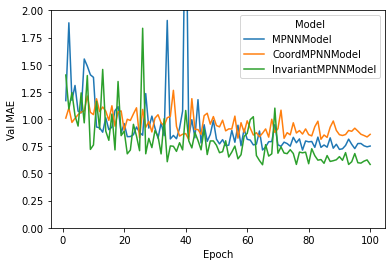

In [35]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

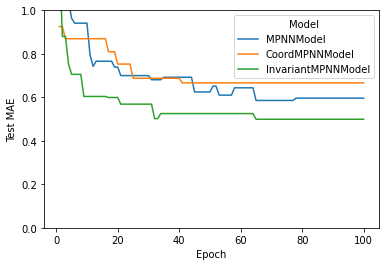

In [36]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Awesome! You have now gone from a vanilla `MPNNModel`, to a naive use of coodinate information in `CoordMPNNModel`, to a more geometrically principled approach in `InvariantMPNN` model. The next step would be building an `EquivariantMPNN` model, but we can stop here 😀

---
---
---

[Fin.](https://www.youtube.com/watch?v=b9434BoGkNQ)